In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
def append_ones(matrix):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

# MNIST dataset

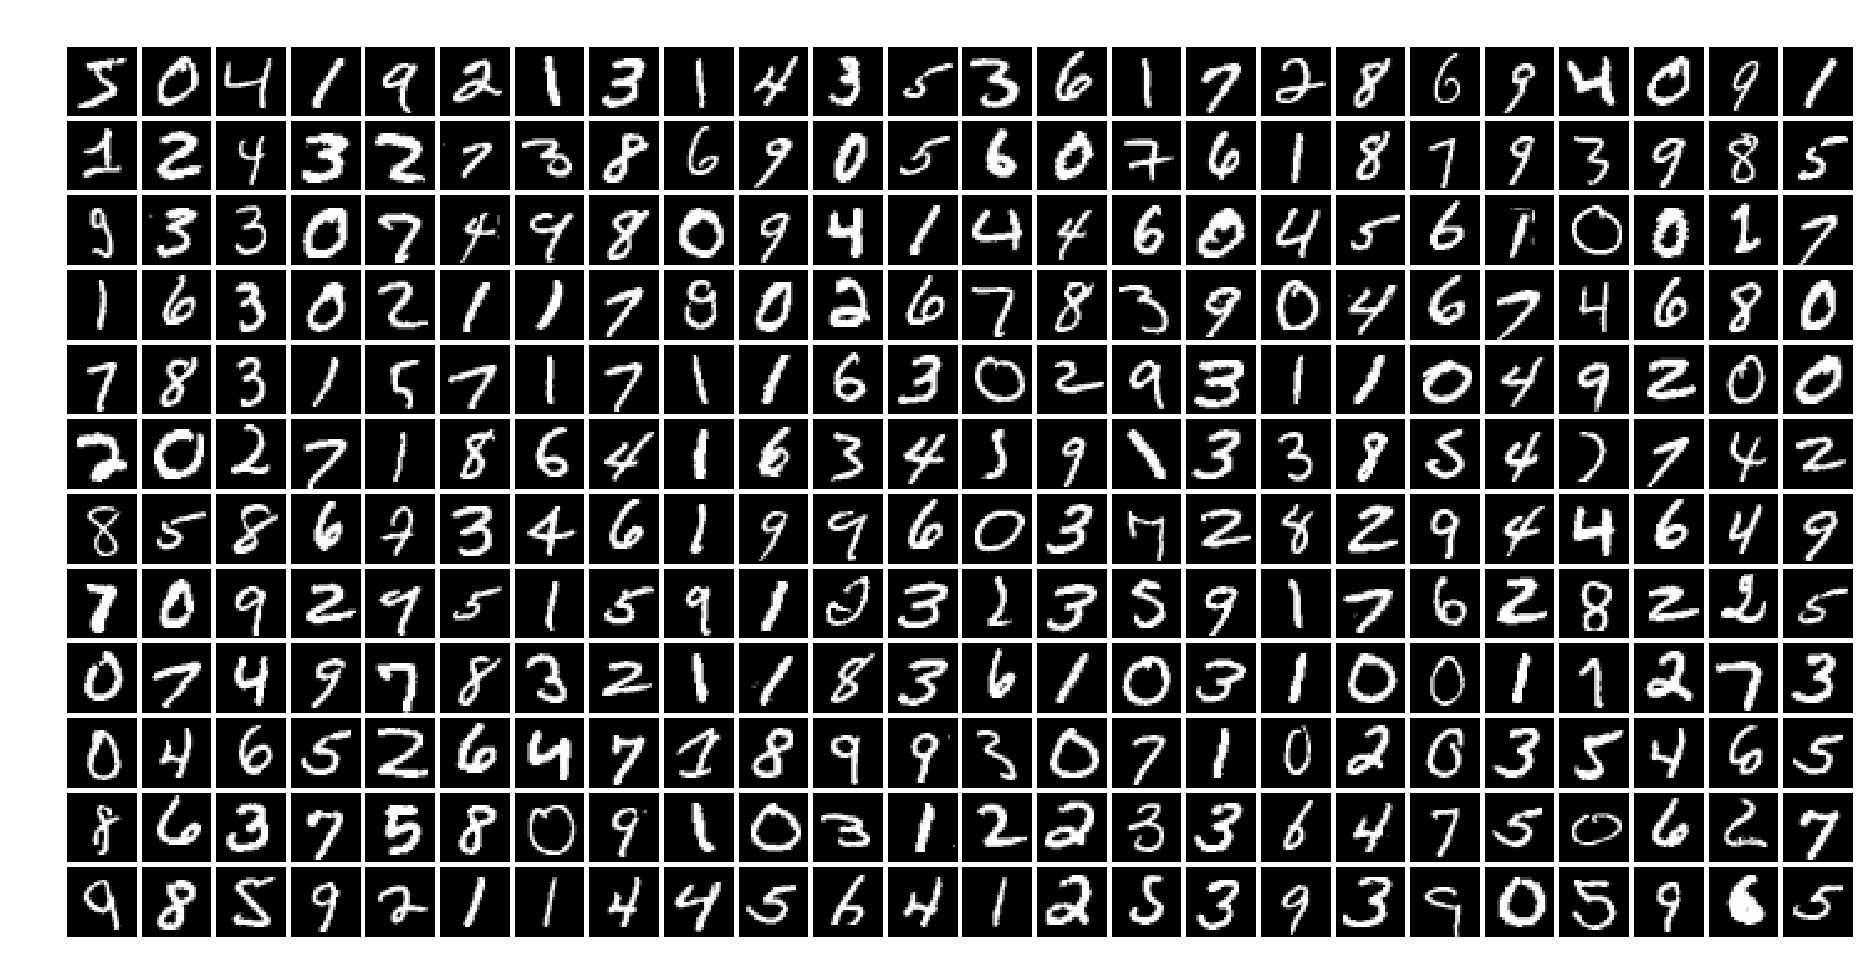

In [3]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [4]:
def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.reset()
        
    def reset(self):
        self.W = np.random.normal(scale=0.01,
                                  size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0

## Contrastive Divergence algorithm

$\newcommand{\vect}[1]{\mathbf{#1}}$
In an RBM the gradient of the cost function with respect to the weights is:

$\frac{\delta}{\delta w_{ij}} -\log P(\vect{v}) = -\mathbf{E}[v_i h_j \vert \vect{v}] + \mathbf{E}[v_i h_j]$

#### Positive phase - calculation of $\mathbf{E}[v_i h_j \vert \vect{v}]$

This part of the gradient is calculated as products $v_i h_j$ between the entries in the observation vector ($v_i$) and activation probabilities in the hidden layer ($h_j$). We can express this operation in the following vectorized form:

$\nabla_P = \vect{v}^T\sigma(\vect{vW})$

#### Negative phase - calculation of $\mathbf{E}[v_i h_j]$

We start from the activation probabilities in the hidden layer that were calculated during the positive phase. Using these probabilities we sample activations in the hidden layer:

$\vect{h} = \sigma (\vect{vW}) > [rand_1, rand_2, \dots, rand_m]$

Next, we sample activations in the visible layer:

$\vect{v}_1 = \sigma (\vect{hW}^T) > [rand_1, rand_2, \dots, rand_n]$

To construct an RBM *fantasy*, we repeat the above steps (alternately) $k$ times (where $k$ is a parameter of the CK-*k* algorithm):

$\vect{h}_{k-1} = \sigma (\vect{v}_{k-1}\vect{W}) > [rand_1, rand_2, \dots, rand_m]$, 
$\vect{v}_k = \sigma (\vect{h}_{k-1}\vect{W}^T) > [rand_1, rand_2, \dots, rand_n]$

The negative part of the gradient is calculated as products $v_{k_i} h_j$ between the entries in the RBM *fantasy* ($v_{k_i}$) and activation probabilities in the hidden layer corresponding to that RBM *fantasy* ($h_j$). We can express this operation in the following vectorized form:

$\nabla_N = \vect{v}_k^T\sigma(\vect{v}_k\vect{W})$

#### Weight matrix update

We are training the RBM with a stochastic gradient descent:

$\phi_{t+1} \leftarrow \phi_t - \epsilon \nabla$

which gives a following update formula for the RBM weights:

$W_{t+1} \leftarrow W_t + \epsilon \nabla_P - \epsilon \nabla_N$

In [11]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))

    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    
   
    positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
    positive_gradient = positive_visible.transpose() @ positive_hidden
    
    negative_hidden[:, :-1]=(positive_hidden[:,:-1] > rand(observations_count , rbm.hidden_size)).astype(np.float32)
    
    for i in range(k):
        negative_visible[:, :-1]=sigmoid(negative_hidden @ rbm.W[:-1, :].transpose())>rand(observations_count,rbm.visible_size).astype(np.float32)
        negative_hidden[:, :-1]=sigmoid(negative_visible @ rbm.W[:, :-1]) 
        if i<k-1:
            negative_hidden[:,:-1]=(negative_hidden[:,:-1]>rand(observations_count,rbm.hidden_size).astype(np.float32))

    negative_gradient=negative_visible.transpose() @ negative_hidden
    
    rbm.W = rbm.W + (positive_gradient * rbm.learning_rate) / observations_count - (negative_gradient * rbm.learning_rate) / observations_count                                                      
#raise Exception("Not implemented!")

## RBM reconstruction error

In [6]:
def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    
    hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1])
    hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size)).astype(np.float32)
    
    visible = sigmoid(hidden @ np.transpose(rbm.W[:-1, :]))
    
    error = minibatch[:, :-1] - visible
    error = np.sum(np.square(error)) / observations_count
    
    return error

# RBM Training

In [7]:
import time

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128
LEARNING_RATE = 0.1

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = np.reshape(mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

rbm = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE)

In [8]:
def draw_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    filters = np.clip(filters, -1, 1)
    tiles(filters)

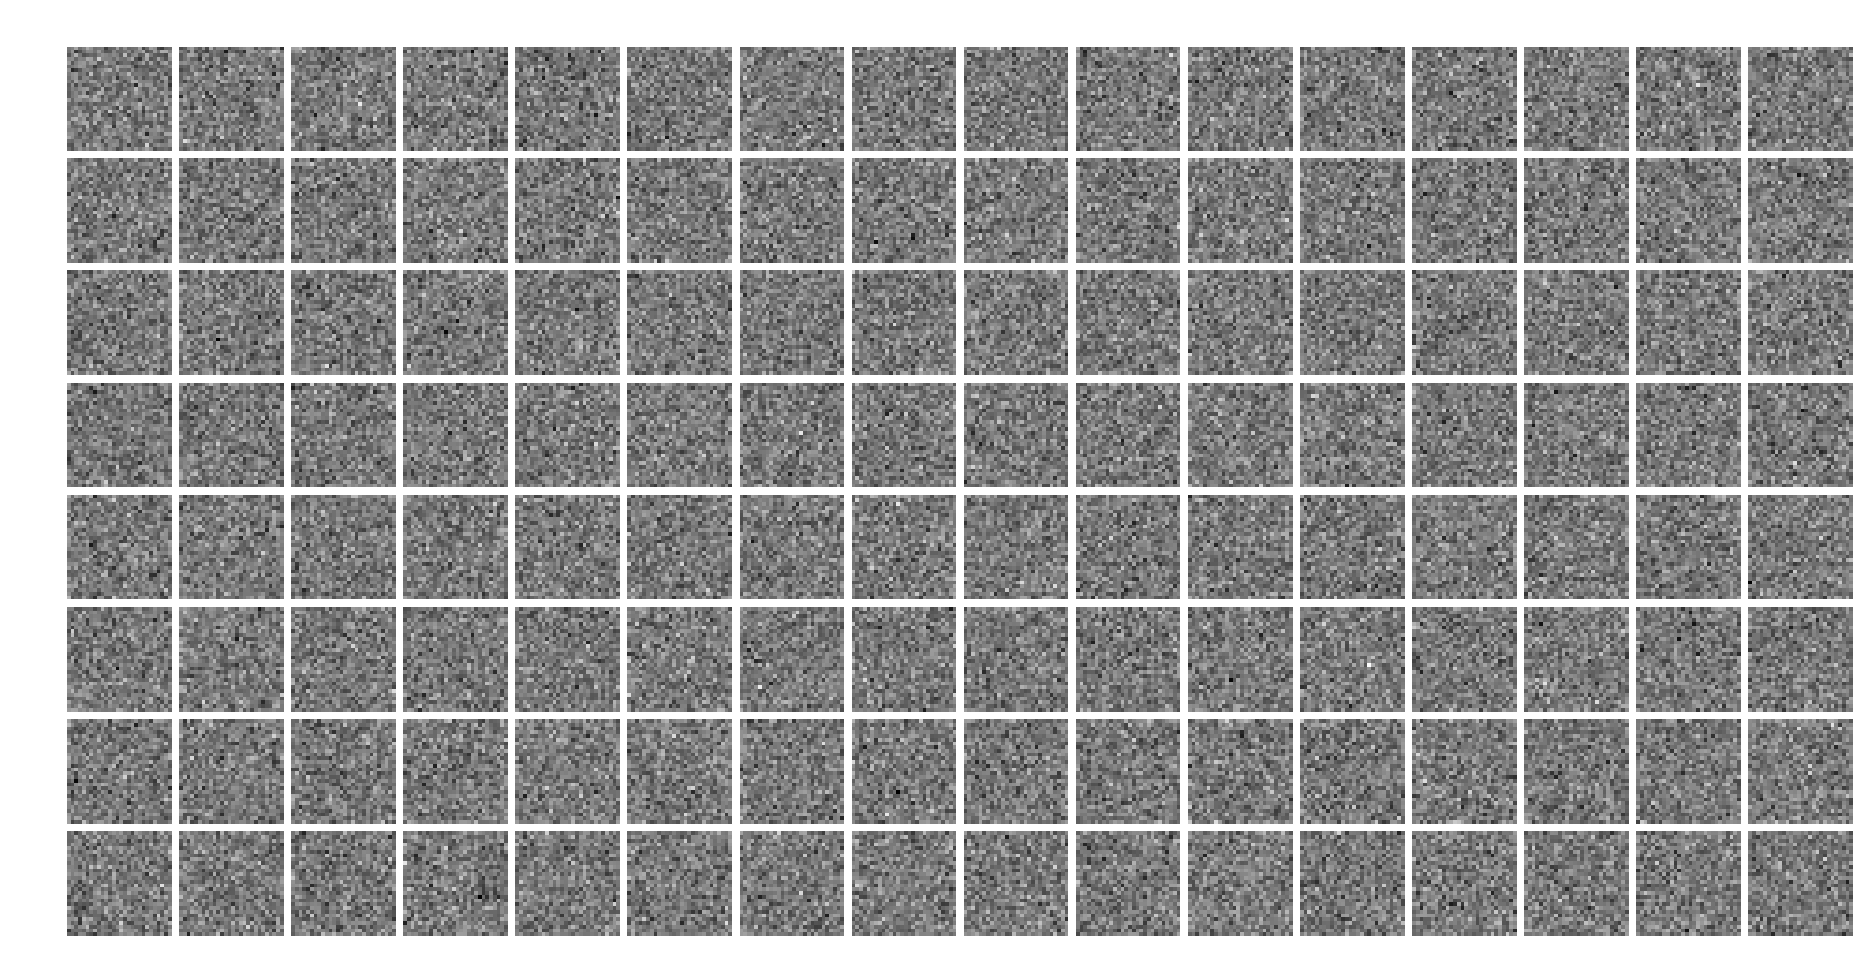

In [9]:
draw_filters(rbm)

In [12]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

def train_epoch(rbm, dataset):
    batches_limit = dataset.shape[0] / BATCH_SIZE
    for batch_idx, batch in enumerate(chunks(dataset, BATCH_SIZE)):
        cdk(rbm, batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

rbm.reset()
for epoch in range(EPOCHS_COUNT):
    print("Epoch {}:".format(epoch + 1),  end="\t")
    
    start_time = time.time()
    train_epoch(rbm, dataset)
    
    elapsed = time.time() - start_time
    error = reconstuction_error(rbm, monitoring_set)
    print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))
    
print("Training finished!")

Epoch 1:	#####################################################	elapsed: 2.10s, reconstruction error: 32.15
Epoch 2:	#####################################################	elapsed: 1.69s, reconstruction error: 25.77
Epoch 3:	#####################################################	elapsed: 1.66s, reconstruction error: 22.72
Epoch 4:	#####################################################	elapsed: 1.65s, reconstruction error: 20.98
Epoch 5:	#####################################################	elapsed: 1.63s, reconstruction error: 19.55
Epoch 6:	#####################################################	elapsed: 1.62s, reconstruction error: 18.55
Epoch 7:	#####################################################	elapsed: 1.59s, reconstruction error: 17.74
Epoch 8:	#####################################################	elapsed: 1.62s, reconstruction error: 17.07
Epoch 9:	#####################################################	elapsed: 1.62s, reconstruction error: 16.46
Epoch 10:	###########################

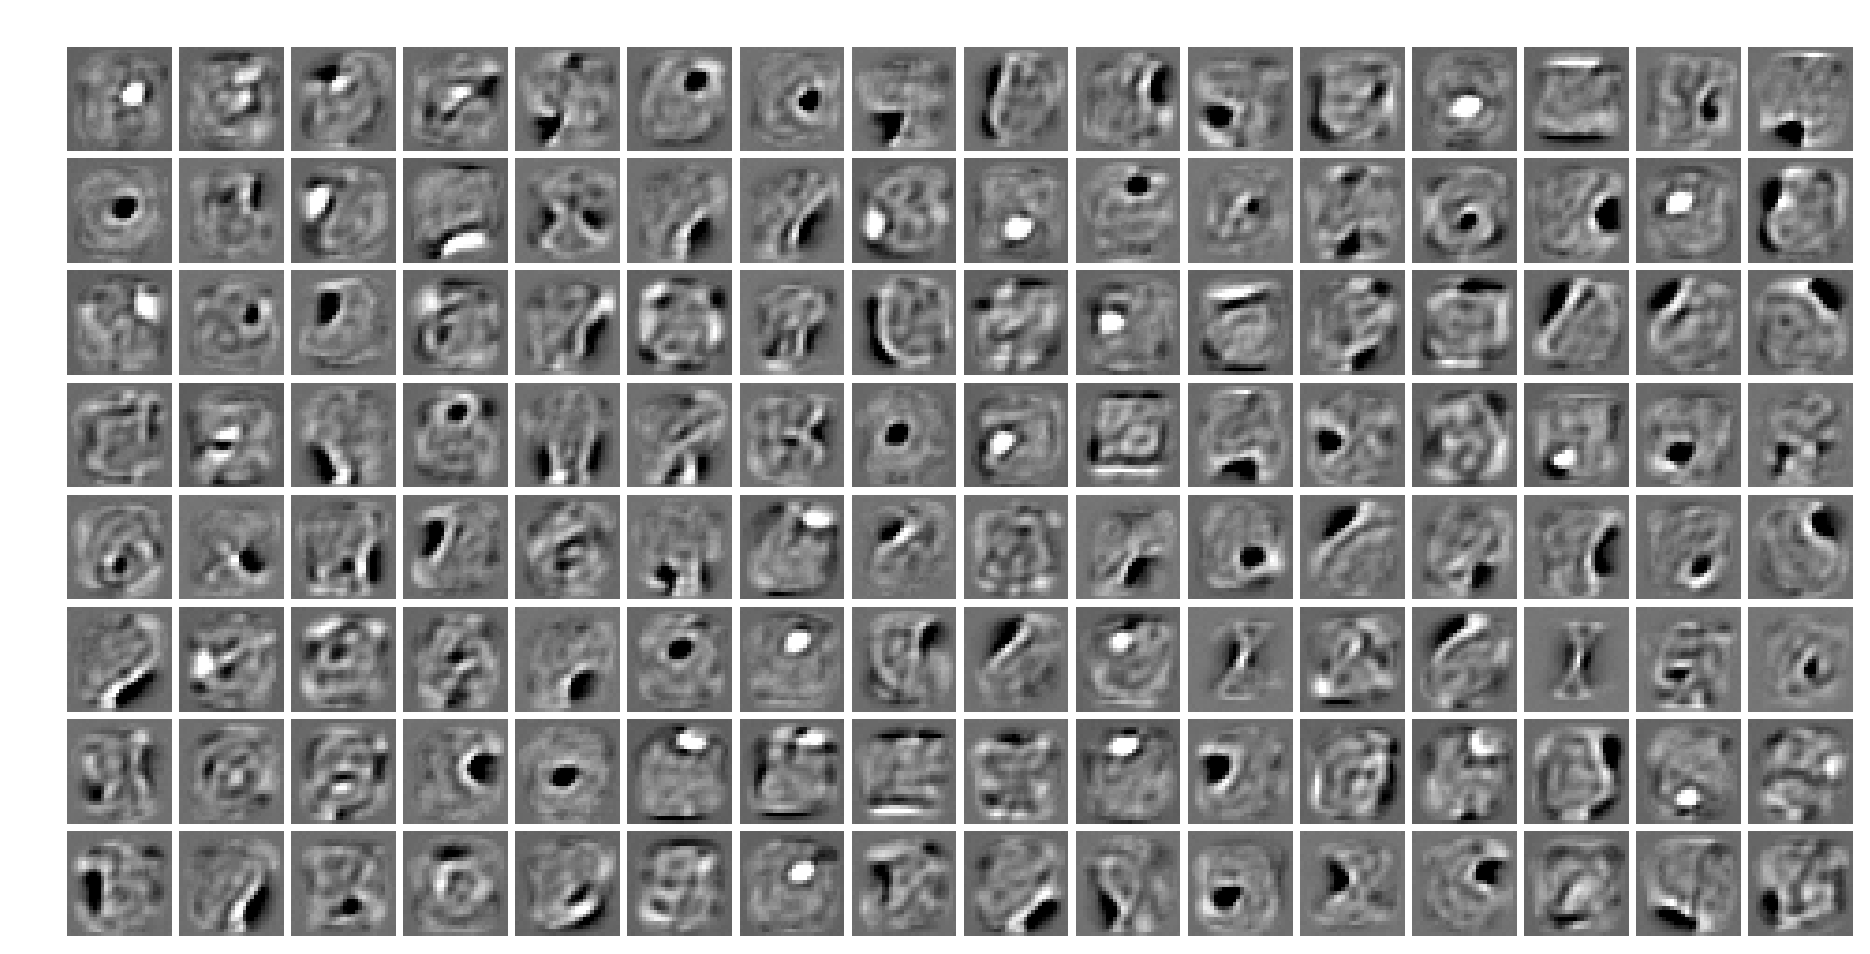

In [13]:
draw_filters(rbm)